<div style="float:left">
    <h1 style="width:450px">Practical 7: Working with Text</h1>
    <h2 style="width:450px">The basics of text mining and NLP</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

A lot of the content here is provided to help you *understand* what text-cleaning does and how it generates tokens that can be processed by the various analytical approaches commonly-used in NLP. The later parts are largely complete and ready to run; however, that *doesn't* mean you should just skip over them and think you've grasped what's happening and it will be easy to apply in your own analyses. I would *not* pay as much attention to LDA topic mining since I don't think it's results are that good, but I've included it here as it's still commonly-used in the Digital Humanities and by Marketing folks. Word2Vec is much more powerful: we'll use it this week to see how you can find similar words, next week we'll use it cluster *documents*.

## Preamble

This practical has been written using `nltk`, but would be _relatively_ easy to rework using `spacy`. Most programmers tend to use one *or* the other, and the switch wouldn't be hard other than having to first load the requisite language models:
```python
import spacy
nlp = spacy.load("en_core_web_sm") # `...web_md` and `...web_lg` are also options
```
You can [read about the models](https://spacy.io/models/en), and note that they are also [available in other languages](https://spacy.io/usage/models) besides English.

## Task 1. Setup

<div class="alert alert-block alert-success">
    <b>Difficulty Level</b>: easy, but only because this has been worked out for you. Starting from sctach in NLP is <em>hard</em> so people try to avoid it as much as possible.
</div>

### Task 1.1 Required Modules

<div class="alert alert-block alert-info">
    Notice that the number of modules and functions that we import is steadily increasing week-on-week, and that for text processing we tend to draw on quite a wide range of utilies! That said, the three most commonly used are: <tt>sklearn</tt>, <tt>nltk</tt>, and <tt>spacy</tt>.
</div>

Standard libraries we've seen before.

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import re
import math
import matplotlib.pyplot as plt

Vectorisers we will use from the 'big beast' of Python machine learning: Sci-Kit Learn.

In [2]:
from sklearn.preprocessing import OneHotEncoder # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

NLP-specific libraries that we will use for tokenisation, lemmatisation, and frequency analysis.

In [3]:
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

Remaining libraries that we'll use for processing and display text data. Most of this relates to dealing with the various ways that text data cleaning is *hard* because of the myriad formats it comes in.

In [4]:
import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

### Task 1.1: Configure

There isn't a lot to configure for this week, but you *will* want to examine the results from the first pass through the data in order to update the list of **stopwords**:

In [5]:
#nltk.download('wordnet') # <-- These are done in a supporting tool, but in your own
#nltk.download('averaged_perceptron_tagger') # application you'd need to import them
stopword_list = set(stopwords.words('english'))

This next is just a small utility function that allows us to output Markdown (like this cell) instead of plain text:

In [6]:
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

### Task 1.2: Loading Data

Remember this function from last week? We use it to save downloading files that we already have stored locally. 


In [7]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

<div class="alert alert-block alert-success">
    <b>&#128161; Tip</b>: for very large <em>non</em>-geographic data sets, remember that you can <tt>use_cols</tt> (or <tt>columns</tt> for feathers) to specify a subset of columns to load.
</div>

Load the main data set:

In [8]:
# Set download URL
host = 'https://orca.casa.ucl.ac.uk'
path = '~jreades/data/'
fn   = '2022-09-10-listings.geofeather'
url  = f'{host}/{path}/{fn}'

gdf = gpd.read_feather( cache_data(url, os.path.join('data','geo')), 
                      columns=['index', 'geometry', 'id', 'listing_url', 'name', 
                               'description', 'amenities', 'price']).set_index('id')

Found data/geo/2022-09-10-listings.geofeather locally!


In [9]:
print(f"gdf has {gdf.shape[0]:,} rows.")

gdf has 68,741 rows.


In [10]:
gdf = gdf.to_crs(epsg=27700)

Load supporting Geopackages:

In [11]:
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

Found data/geo/Boroughs.gpkg locally!
Found data/geo/Water.gpkg locally!
Found data/geo/Greenspace.gpkg locally!
Done.


### Task 1.3: Remove NaN Values

<div class="alert alert-block alert-warning">
    <b>&#9888; Note</b>: I would be wary of doing the below in a 'proper' application without doing some careful research first, but to make our lives easier, we're going to drop rows where one of these values is NaN _now_ so it will simplify the steps below. In reality, I would spend quite a bit more time investigating which values are NaN and why before simply dropping them.
</div>

Anyway, drop all rows where the description or amenities are `NaN`:

In [12]:
gdf = gdf.dropna(subset=['description','amenities'])
print(f"Now gdf has {gdf.shape[0]:,} rows.")

Now gdf has 67,475 rows.


## Task 2. Exploratory Textual Analysis

It's helpful to have a sense of what these data look like before trying to do something with them. You can also change the amount of preview text provided using the pandas options:
```python
print(pd.options.display.max_colwidth) # What's this currently set to?
pd.options.display.max_colwidth=100    # What do we want to set it to?
```

<div class="alert alert-block alert-success">
    <b>&#128161; Tip</b>: In a full text-mining application I would spend a lot more time on this stage: sampling, looking at descriptions in full, performing my analysis (the rest of the steps) and then coming back with a deeper understanding of the data to make further changes to the analysis.
</div>

In [13]:
print(f"Default maximum column width: {pd.options.display.max_colwidth}") # What's this currently set to?
pd.options.display.max_colwidth=250   # None = no maximum column width (you probably don't want to leave it at this)

Default maximum column width: 50


### Task 2.1: Description Field

<div class="alert alert-block alert-warning">
    <b>Difficulty Level</b>: Medium, because of the questions.
</div>

Technically, filtering is no longer needed, but I want you to learn how to find any description that *is NA* (that's a clue) in the data. But the code below should *then* **filter out any NA descriptions**.

In [14]:
gdf[~gdf.description.isna()].description.sample(5, random_state=42)

id
699053507371704448                                                                                                                                                                                                                                        Recently refurbished.
53382856              ✪ MARCH BOOKINGS - DISCOUNTED RATES ✪<br /><br />★ JB Stays Serviced Accommodation Wimbledon☎<br /><br />☛ 1 Bed Apartment<br />❅  Sleeps Up to 2 Guests<br />☛ Common space – 1 Sofa bed<br />❅  Free WiFi <br />☛ Fully Equipped Kitchen<br />❅  A s...
21068222              Beautiful, newly redecorated period house, with genuine Edwardian touches and styling. Bright and airy, lots of light, secret lush garden. Direct sunlight travels around the house all day long. The property benefits from a spacious kitchen with d...
25912554              Welcome to Applecourt, a lovely self-contained cedar-clad cabin with its own private drive and courtyard.<br /><br />Located just 1 minute away from the A3 on 

<div class="alert alert-block alert-danger">
    <b>&#9888; Stop</b>: what do you notice about the above? Are they simple text? are there patterns of problems? Are there characters that represent things other than words and simple punctuation?
</div>

#### 2.1.1 Questions

- What patterns can you see that might need 'dealing with' for text-mining to work?

To me the most obvious ones are the HTML (`<...>` and `</...>` or `<.../>`) and the fact that every description ends `...`. To me this is a _major_ warning: the fact that so many in our small sample end '...' makes me think that we may not have the _full_ description of the property. This doesn't mean the data is useless, but it does mean we're more limited that certainly _I_ would like normally.

- What non-text characters can you see? (Things *other* than A-Z, a-z, and simple punctuation!)

There are a _lot_ of these to think about, not just the HTML 'tags'. There are also `•` and `-`, `10mins` and other numbers, and even emoticons (`:-)`). We're also going to see some raw Unicode (stuff beginning `\u...` though it's not obvious here).

### Task 2.2: Amenities Field

<div class="alert alert-block alert-warning">
    <b>Difficulty Level</b>: Medium, because of the questions.
</div>

This field presents a subtle issue that might not be obvious here:

In [15]:
gdf.amenities.sample(5, random_state=42)

id
699053507371704448                                                                                                                           ["Washer", "Long term stays allowed", "TV", "Smoke alarm", "Paid parking on premises", "Carbon monoxide alarm", "Kitchen", "Wifi"]
53382856              ["Essentials", "Extra pillows and blankets", "Hot water", "Free parking on premises", "Long term stays allowed", "Shampoo", "Microwave", "HDTV with ", "Refrigerator", "Smoke alarm", "Cooking basics", "Bed linens", "Lockbox", "Iron", "Hangers", "K...
21068222                                                                    ["Wifi", "First aid kit", "Washer", "Free parking on premises", "Shampoo", "Long term stays allowed", "Fire extinguisher", "Smoke alarm", "Hair dryer", "Lockbox", "Hangers", "Kitchen", "Heating"]
25912554              ["Extra pillows and blankets", "First aid kit", "Hair dryer", "Private entrance", "Hangers", "Crib", "Dishes and silverware", "Essentials", "Free parking on pr

But look what happens here, can you see the issue?

In [16]:
gdf.amenities.iloc[0]

'["Extra pillows and blankets", "Oven", "Fire extinguisher", "Hair dryer", "Hangers", "Crib", "Dishes and silverware", "Luggage dropoff allowed", "Essentials", "Outlet covers", "Patio or balcony", "Shampoo", "Free parking on premises", "TV with standard cable", "Free street parking", "Cooking basics", "Bed linens", "Babysitter recommendations", "Carbon monoxide alarm", "Bathtub", "Heating", "Wifi", "Building staff", "Children\\u2019s books and toys", "Coffee maker", "Long term stays allowed", "Pack \\u2019n play/Travel crib", "Refrigerator", "Room-darkening shades", "Iron", "Kitchen", "Stove", "Lock on bedroom door", "Hot water", "Washer", "Paid parking off premises", "Children\\u2019s dinnerware", "Smoke alarm", "Ethernet connection", "Dryer", "Cable TV"]'

#### 2.2.1 Questions

- What's the implicit format of the Amenities columns?

Implicitly, this is formatted as a list _in the form of a string_ so you would need to 'deserialise' it using either regular expressions/str.split() _or_ some kind of `eval` (more on that [here](https://www.programiz.com/python-programming/methods/built-in/eval)). Eval is a seriously dangerous method if you don't know what you're doing... but below you'll see a generically safe way to manage simple evals.

- How could you represent the data contained in the column?

You _can_ store this as a list in pandas/geopandas, but you will often *not* be able to write it to a feather/geogeather without 're-serialising' it into something like the original data. To my mind this could be a good candidate for One-Hot Encoding/Dummy encoding after doing a little investigation of the frequency-of-use (_ie_ do you want to dedicate an entire column in an 80k data frame to an amenity that only occurs in 2 listings? *Or* do you want to dedicate an entire column to something found in 95% of listings?).

## Task 3. Using Regular Expressions

There is a _lot_ that can be done with Regular Expressions to identify relevant records in textual data and we're going to use this as a starting point for the rest of the analysis. I would normally consider the regexes here a 'first pass' at the data, but would look very carefully at the output of the TF/IDF vectorizer, Count vectorizer, and LDA to see if I could improve my regexes for further cycles of analysis... the main gain there is that regexes are _much_ faster than using the full NLP (Natural Language Processing) pipeline on the _full_ data set each time. As an alternative, you could develop the pipeline using a random subsample of the data and then process the remaining records sequentially -- in this context there is no justification for doing that, but with a larger corpus it might make sense.

### Task 3.1: Luxury Accommodation

<div class="alert alert-block alert-danger">
    <b>Difficulty Level</b>: Hard, because of the regular expression and questions.
</div>

I would like you to find listings that *might* (on the basis of word choice) indicate 'luxury' accommodation.

#### 3.1.1 Create the Regular Expression

You should start with variations on 'luxury' (i.e. luxurious...) and work out a **single regular expression** that works for variations on this *one* word. Later, I would encourage you to consider what other words might help to signal 'luxury'... perhaps words like 'stunning' or 'prestigious'? Could you add those to the regex as well?

*Hints*: this is a toughy, but here are some hints:

1. All regular expressions work best using the `r'...'` (which means raw string) syntax.
2. You need to be able to *group* terms. In Python, however, 'group' refers to matching, whereas what you need here is a "non-capturing group" of the **positive lookahead** type. 
3. In fact, to deal with *everything* you might even need more than one of these in a *nested* structure.

In [30]:
gdf[
    gdf.description.str.contains(r'(?:luxur(?:y|ious|iat)|prestigious|stunning)', regex=True, flags=re.IGNORECASE) # <-- The regex
].description.sample(5, random_state=42)

id
659304585594704256    Just a few minutes away from the world-famous Wembley Stadium, this accommodation is situated in the prestigious suburban town of Wembley in north-west London. <br /> <br />Located just five minutes away on foot from Wembley Park London Undergrou...
675790472963965696    Discover the best of London, with this one-bedroom Croydon apartment with high floor views over the city. It’ll be easy to simply show up and start living in this modernly Blueground furnished apartment with its fully-equipped kitchen, cozy livin...
16825932              Newly modernised built studio in south west London.  Studio has a luxurious  high end look with white walls and floor in living area and marble floor for en-suite bathroom also electric windows.   It's Close-by to train and tube links into centra...
34491809              This lovely two-bedroom apartment is the perfect base when visiting London, ideally located for access to Central London with Rectory Road and Stoke Newington 

#### 3.1.2 Apply it to Select Data
Assign it to a new data frame called `lux`:

In [31]:
lux = gdf[gdf.description.str.contains(r'(?:luxur(?:y|ious|iat)|prestigious|stunning)', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {lux.shape[0]:,} records for 'luxury' flats")

Found 7,469 records for 'luxury' flats


#### 3.1.3 Plot the Data

Now we are going to create a more complex plot that will give space to both the spatial and price distributions using `subplot2grid`.

In [19]:
help(plt.subplot2grid)

Help on function subplot2grid in module matplotlib.pyplot:

subplot2grid(shape, loc, rowspan=1, colspan=1, fig=None, **kwargs)
    Create a subplot at a specific location inside a regular grid.
    
    Parameters
    ----------
    shape : (int, int)
        Number of rows and of columns of the grid in which to place axis.
    loc : (int, int)
        Row number and column number of the axis location within the grid.
    rowspan : int, default: 1
        Number of rows for the axis to span downwards.
    colspan : int, default: 1
        Number of columns for the axis to span to the right.
    fig : `.Figure`, optional
        Figure to place the subplot in. Defaults to the current figure.
    **kwargs
        Additional keyword arguments are handed to `~.Figure.add_subplot`.
    
    Returns
    -------
    `.axes.SubplotBase`, or another subclass of `~.axes.Axes`
    
        The axes of the subplot.  The returned axes base class depends on the
        projection used.  It is `~.axe

Notice that there are two ways to create the plot specified above. I chose route 1, but in some ways route 2 (where you specify a `gridspec` object and *then* add the axes might be a bit simpler to work out if you're starting from scratch.

The critical thing here is to understand how we'er initialising a plot that has **4 rows** and **1 column** even though it is only showing **2 plots**. What we're going to do is set the *first* plot to span **3 rows** so that it takes up 75% of the plot area (3/4), while the *second* plot only takes up 25% (1/4). They will appear one above the other, so there's only 1 column. Here's how to read the key parts of `subplot2grid`:
- `nrows` -- how many rows *of plots* in the figure.
- `ncols>` -- how many columns *of plots* in the figure.
- `row` -- what row of the figure does *this* plot start on (0-indexed like a list in Python).
- `col` -- what column of the figure does *this* plot start on (0-indexed like a list in Python).
- `rowspan` -- how many rows of the figure does *this* plot span (*not* 0-indexed because it's not list-like).
- `colspan` -- how many columns of the figure does *this* plot span (*not* 0-indexed because it's not list-like).

Every tie you call `subplot2grid` you are initialising a new axis-object into which you can then draw with your geopackage or pandas plotting methods.

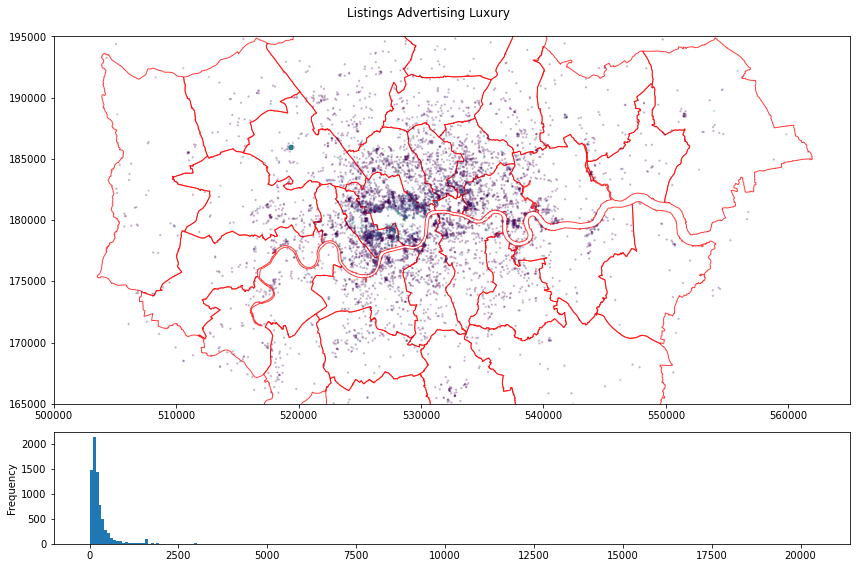

In [41]:

f,ax = plt.subplots(1,1,figsize=(12,8))

# The first plot 
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
lux.plot(markersize=2, column='price', cmap='viridis', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
lux.price.plot.hist(bins=250, ax=ax2)

plt.suptitle("Listings Advertising Luxury") # <-- How does this differ from title? Change it and see!
plt.tight_layout() # <-- Try creating the plot *without* this to see what it changes
plt.show()


#### 3.1.4 Questions

- What does `suptitle` do and how is it different from `title`? Could you use this as part of your plot-making process?

Suptitle adds a 'super-title' to a *figure*, whereas title adds a title an *axis*. So you could, for instance, create sub-titles (using 'title') on a plot that still has an overall title (using super-title).

- What does `tight_layout` do?

You could Google this, but basically it tries to reduce whitspace after all of the elements for a complex plot are in-place. If you don't call this then there is quite a lot of whitespace between the super-title and the first plot.

### Task 3.2: Budget Accommodation

<div class="alert alert-block alert-success">
    <b>Difficulty Level</b>: Easy, because you've worked out the hard bits already.
</div>

#### 3.2.1 Create the Regular Expression

What words can you think of that might help you to spot affordable and budget accommodation? Start with just a couple of words and then I would encourage you to consider what _other_ words might help to signal 'affordability'... perhaps words like 'cosy' or 'charming' and then think about how you could you add those to the regex?

*Hints*: this just builds on what you did above with one exception:

1. I'd try adding word boundary markers to the regex (`\b`) where appropriate...

In [36]:
gdf[
    gdf.description.str.contains(r'\b(?:affordable|budget|cheap|charm(?:ing)?|cosy)\b', regex=True, flags=re.IGNORECASE)
].description.sample(5, random_state=42)

id
45492177              These days we offer self-check-in to all our guests. Once booking is confirmed, full instructions will be sent. Scan copies of IDs required prior to arrival.<br />Should you require any help please use Airbnb messaging service or call  o2o7 6o3 3...
686254052484572544    Charming family upstairs maisonette home - 3 bedroom (one king size double, one bunkbed, one single), 2 bathroom with pretty outdoor garden space / eating area.  Fantastically located with independent coffee shops, bars and shops all a stones thr...
5002791               Cosy, comfortable and welcoming 1 bedroom flat located 5 minutes (by foot) from Highgate tube station. Highgate Wood, Highgate Village, Muswell Hill and Hampstead Heath are all within easy walking distance.<br /><br />Kitchen<br />Includes breakf...
9689249               Beautiful flat for xmas/new year. 2 double bedrooms + 1 large living room. Light and modern. Tucked away in a tranquil, leafy corner of inner-city Hackney - be

#### 3.2.2 Apply it to Select Data

In [35]:
aff = gdf[gdf.description.str.contains(r'\b(?:affordable|budget|cheap|charm(?:ing)?|cosy)\b', regex=True, flags=re.IGNORECASE)].copy()
print(f"There are {aff.shape[0]:,} rows flagged as 'affordable'.")

There are 9,824 rows flagged as 'affordable'.


#### 3.2.3 Plot the Data

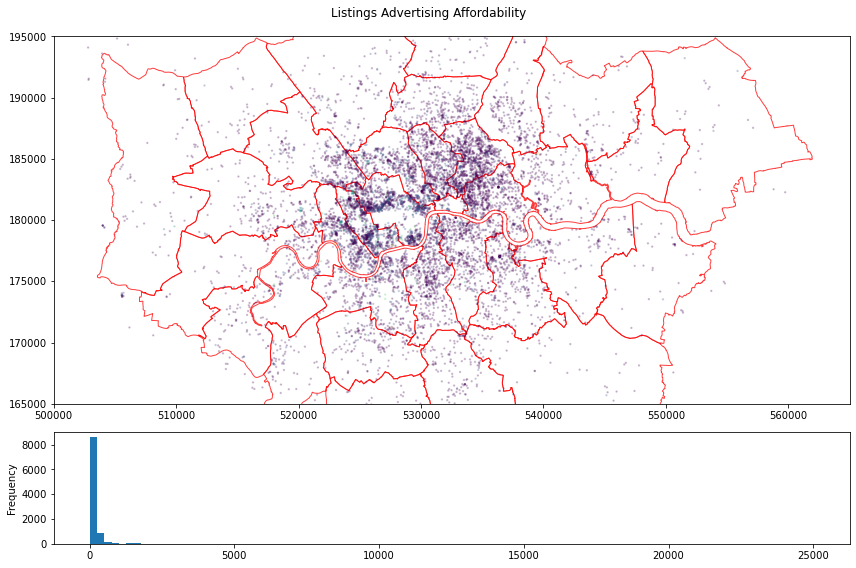

In [44]:

f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
aff.plot(markersize=2, column='price', cmap='viridis', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
aff.price.plot.hist(bins=100, ax=ax2)

plt.suptitle("Listings Advertising Affordability")
plt.tight_layout()
plt.savefig("Affordable_Listings.png", dpi=150)
plt.show()

#### 3.2.4 Questions

- Do you think that this is a *good* way to select affordable options?

Probably not without some additional thought, see: `aff.price.max()`, but perhaps filtering on something like `aff.price.quantile(0.95)` or the 75th percentile would help? We'd need to think about the rationale for doing so.

- Do you understand what `dpi` means and how `savefig` works?

`dpi` is short for dots per inch, and higher values will output high-quality plots (that also take up more disk space on your hard drive, so use with care!). In general, a screen was assumed for a long time to be 96dpi, though modern monitors are higher resolution than this. Something for *decent* printed output or for sharing online would be done at 150 or *higher* dpi. Something for a 'proper' report or for printing out in a thesis would be in the range 300-600dpi. 

Notice that we don't specify a format separately from the file name. Matplotlib will use the filename extension (`.png` in this case) to pick the right format. It supports a wide range of formats that you might want to consider: `.png` (good for sharing and size), `.tiff` (good for printing at high quality), `.pdf` (good for inclusion in LaTeX/Markdown files and especially for vector formats). The only problem with PDFs is that matplotlib has a tendency to use raster output *in* the PDF even when the data itself is vector-based. Try it and see!

- Modify the code above to constrain the histogram on a more limited distribution by *filtering* out the outliers *before* drawing the plot. I would copy the cell above to one just below here so that you keep a working copy available and can undo any changes that break things.

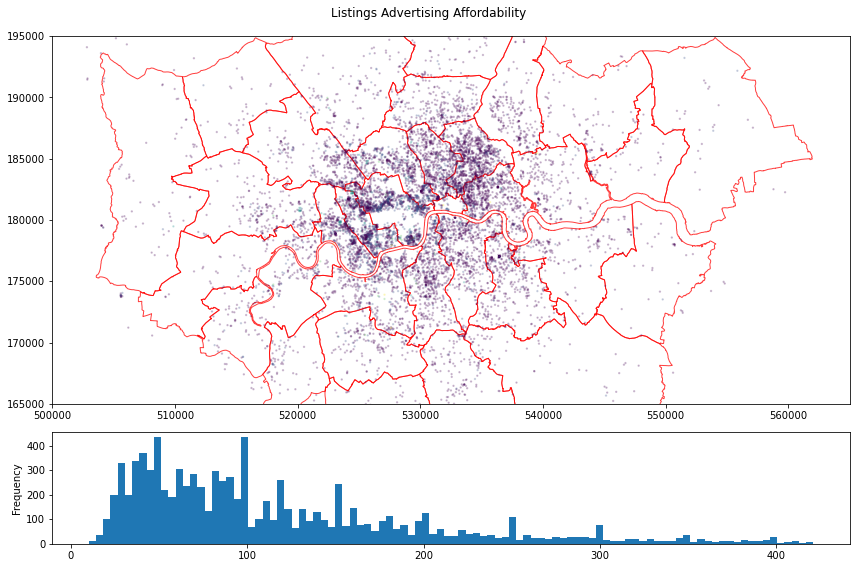

In [45]:

f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
aff.plot(markersize=2, column='price', cmap='viridis', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
aff[aff.price<aff.price.quantile(0.95)].price.plot.hist(bins=100, ax=ax2)
#ax2.set_ylim([0,10000])

plt.suptitle("Listings Advertising Affordability")
plt.tight_layout()
plt.savefig("Affordable_Listings.pdf", dpi=600)
plt.show() # <-- this *must* come at the end or you will get empty plots saved

### Task 3.3: Near Bluespace

<div class="alert alert-block alert-success">
    <b>Difficulty Level</b>: Easy, because you've worked out the hard bits already.
</div>

Now see if you can work out a regular expression to find accommodation that emphasises accessibility to the Thames and other 'blue spaces' as part of the description? One thing you'll need to tackle is that some listings seem to say something about Thameslink and you wouldn't want those be returned as part of a regex looking for _rivers_.

#### 3.3.1 Creat the regular Expression

In [46]:
gdf[
    gdf.description.str.contains(r'(?:Thames|river|water)(?: view|\s?front)\b', regex=True, flags=re.IGNORECASE)
].description.sample(5, random_state=42)

id
9730602               Near the Kings Road and close to great restaurants, shops and cafes, the apartment is an easy walking distance to the Thames riverfront and South Park.<br /><br />The apartment has two double bedrooms, a good-sized living room and a large basemen...
18719193              The space:<br />We are offering a private room with double bed and your own bathroom. The flat is spacious with a contemporary interior design and featuring a balcony with view over the river Thames. The development offers a gym (free access), gr...
607970245151706496    A spacious 1 bedroom apartment, perfect for a couple or single person in London. <br />High spec bathroom and kitchen and stylishly furnished, with west facing balcony with river view and large windows, creating a light and bright space. <br />Lo...
13769236              Hello !<br /><br />My lovely waterfront house is a short walk to Surrey Quays Tube (5 minutes) and Canada Water Tube (9 minutes) , giving fast and easy access 

#### 3.3.2 Apply it to the Select Data

In [48]:
bluesp = gdf[
    (gdf.description.str.contains(r'(?:Thames|river|water)\s*(?:view|front)\b', regex=True, flags=re.IGNORECASE)) |
    (gdf.description.str.contains(r'(?:walk|close|near) to (?:Thames|river|water)', regex=True, flags=re.IGNORECASE))
].copy()
print(f"Found {bluesp.shape[0]:,} rows.")

Found 328 rows.


#### 3.3.3 Plot the Data

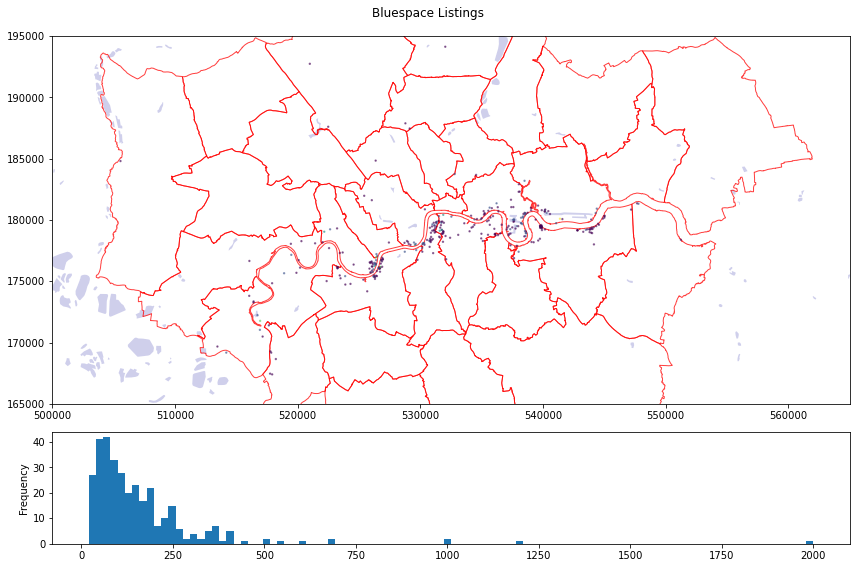

In [49]:

f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
water.plot(edgecolor='none', facecolor=(.25, .25, .7, .25), ax=ax1)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
bluesp.plot(markersize=2, column='price', cmap='viridis', alpha=0.5, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
bluesp.price.plot.hist(bins=100, ax=ax2)

plt.suptitle("Bluespace Listings")
plt.tight_layout()
plt.show()


#### 3.3.4 Questions

- How else might you select listings with a view of the Thames or other bluespaces?

We could try using a buffer and a spatial join! `water.buffer(175)`. We could then use those to look for additional ways that people might describe river-views!

## Task 4. Illustrative Text Cleaning

Now we're going to step through the _parts_ of the process that we apply to clean and transform text. We'll do this individually before using a function to apply them _all at once_.

### Task 4.1: Downloading a Web Page

<div class="alert alert-block alert-success">
    <b>Difficulty Level</b>: Easy.
</div>

There is plenty of good economic geography research being done using web pages. Try using Google Scholar to look for work using the British Library's copy of the *Internet Archive*.

In [28]:
from urllib.request import urlopen, Request

# We need this so that the Bartlett web site 'knows'
# what kind of browser it is deasling with. Otherwise
# you get a Permission Error (403 Forbidden) because
# the site doesn't know what to do.
hdrs = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       }
url = 'https://www.ucl.ac.uk/bartlett/casa/about-0'

# Notice that here we have to assemble a request and
# then 'open' it so that the request is properly issued
# to the web server. Normally, we'd just use `urlopen`, 
# but that doesn't give you the ability to set the headers.
request  = Request(url, None, hdrs) #The assembled request
response = urlopen(request)
html     = response.read().decode('utf-8') # The data u need

print(html[:1000])

<!DOCTYPE html>
<!--[if IE 7]>
<html lang="en" class="lt-ie9 lt-ie8 no-js"> <![endif]-->
<!--[if IE 8]>
<html lang="en" class="lt-ie9 no-js"> <![endif]-->
<!--[if gt IE 8]><!-->
<html lang="en" class="no-js"> <!--<![endif]-->
<head>
  <meta name="viewport" content="width=device-width, initial-scale=1.0"/>
  <meta name="author" content="UCL"/>
  <meta property="og:profile_id" content="uclofficial"/>
  <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
<link rel="shortcut icon" href="https://www.ucl.ac.uk/bartlett/casa/sites/all/themes/indigo/favicon.ico" type="image/vnd.microsoft.icon" />
<meta name="description" content="The Centre for Advanced Spatial Analysis (CASA) is an interdisciplinary research institute focusing on the science of cities within The Bartlett Faculty of the Built Environment at UCL." />
<link rel="canonical" href="https://www.ucl.ac.uk/bartlett/casa/about-0" />
<meta name="ucl:faculty" content="Bartlett" />
<meta name="ucl:org_unit" content="Cent

### Task 4.2: Removing HTML

<div class="alert alert-block alert-warning">
    <b>Difficulty Level</b>: Medium, because what we're doing will seem really strange and uses some previously unseen libraries that you'll have to google.
</div>

You need to need to *get the text* out of the each returned `<p>` and `<div>` element:

In [62]:
cleaned = ''

soup = BeautifulSoup(html)
body = soup.find('body')

for c in body.findChildren(recursive=False):
    if c.name in ['div','p'] and c.get_text().strip() != '': 
        txt = c.get_text(separator=" ").strip()
        cleaned += (re.sub("(?:\s*\n){2,}","",txt, re.MULTILINE))

In [63]:
cleaned

"UCL Home The Bartlett Centre for Advanced Spatial Analysis About \n About    The Centre for Advanced Spatial Analysis (CASA) is an interdisciplinary research institute focusing on the science of cities within The Bartlett Faculty of the Built Environment at UCL. CASA\xa0was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling, sensing the urban environment, visualisation and computation. We seek\xa0to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities. Our vision is to play a central role in the science of smart cities – applying it to city planning, policy and architecture in the pursuit of making our cities better places to live. Based in Bloomsbury, London, CASA is our living laboratory. As one of the world’s truly global metropolises there is nowhere more ideal than London for learning about the challenges confronting modern cities. CASA has establis

### Task 4.3: Lower Case

<div class="alert alert-block alert-success">
    <b>Difficulty Level</b>: Easy.
</div>

In [64]:
lower = [c.lower() for c in cleaned.split("\n") if not re.match("^\s*$", c)]

In [65]:
lower

['ucl home the bartlett centre for advanced spatial analysis about ',
 " about    the centre for advanced spatial analysis (casa) is an interdisciplinary research institute focusing on the science of cities within the bartlett faculty of the built environment at ucl. casa\xa0was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling, sensing the urban environment, visualisation and computation. we seek\xa0to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities. our vision is to play a central role in the science of smart cities – applying it to city planning, policy and architecture in the pursuit of making our cities better places to live. based in bloomsbury, london, casa is our living laboratory. as one of the world’s truly global metropolises there is nowhere more ideal than london for learning about the challenges confronting modern cities. casa has esta

### Task 4.4: Stripping 'Punctuation'

<div class="alert alert-block alert-danger">
    <b>Difficulty Level</b>: Hard, because you need to understand why we're <em>compiling</em> the regular expression and how to use character classes.
</div>

We want to clear out punctuation using a regex that takes advantage of the `[...]` (character class) syntax. There are two tricky things: 

1. How to specify all the 'punctuation'; 
2. How to *escape* the punctuation (`[`, `]`, `.` and `-` are the main ones) that has a special meaning in a regular expression.

*Hints*: This one is also tough:

1. You will want to match more than one piece of punctuation at a time, so I'd suggest add a `+` to your pattern.
2. You will need to look into *metacharacters* for creating a kind of 'any of the characters *in this class*' (that's an extra hint) bag of possible matches.

In [66]:
pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;\+\–\—]+')
punkt   = []
for l in lower:
    punkt.append(re.sub(pattern, ' ', l))

In [68]:
for p in punkt:
    as_markdown("Line of Text", p)

##### Line of Text

>ucl home the bartlett centre for advanced spatial analysis about 


##### Line of Text

> about    the centre for advanced spatial analysis  casa  is an interdisciplinary research institute focusing on the science of cities within the bartlett faculty of the built environment at ucl  casa was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling  sensing the urban environment  visualisation and computation  we seek to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities  our vision is to play a central role in the science of smart cities   applying it to city planning  policy and architecture in the pursuit of making our cities better places to live  based in bloomsbury  london  casa is our living laboratory  as one of the world s truly global metropolises there is nowhere more ideal than london for learning about the challenges confronting modern cities  casa has established a concentration of academics with a wide breadth of expertise from a range of disciplines  all with a common domain knowledge in cities  our vision casa s focus is to be at the forefront of what is one of the grand challenges of 21st century science: to build a science of cities from a multidisciplinary base  drawing on cutting edge methods  and ideas in modeling  complexity  visualisation and computation  our current mix of geographers  mathematicians  physicists  architects and computer scientists make casa a unique institute within ucl  our vision is to be central to this new science  the science of smart cities  and relate it to city planning  policy and architecture in its widest sense  the focus is on advancing the state of the art through research complemented by graduate study  teaching  consultancy and distance learning  location the ucl centre for advanced spatial analysis is located at 90 tottenham court road  london  w1t 4tj   


##### Line of Text

> view map contact address: ucl centre for advanced spatial analysis first floor  90 tottenham court road london w1t 4tj telephone:   44  0 20 3108 3877 enquiries for all student enquiries  please contact  mohammod hussain  on tel:   44  0 20 3108 3327 for all enquiries  please  email   casa@ucl ac uk jobs vacancies at casa will be listed here  you can also  follow us  on twitter and connect with us on  linkedin   tweets by casaucl


### Task 4.5: Stopword Removal

<div class="alert alert-block alert-warning">
    <b>Difficulty Level</b>: Medium, because you need to remember how list comprehensions work to use the <tt>stopword_list</tt>.
</div>

In [69]:
stopword_list = set(stopwords.words('english'))
print(stopword_list)

{'herself', 'about', 'where', 'd', 'themselves', 'this', 'any', "wasn't", 's', 'here', "it's", 'other', 'ain', 'but', 'by', 'am', 'weren', 'he', 'theirs', 'isn', "hadn't", 'wouldn', 'has', 'until', 'you', 'these', 'its', 'during', 'mustn', 'both', 'your', 'yourself', 'itself', 'again', 'have', "mightn't", 'how', 'they', 'my', 'once', 'because', 'm', "doesn't", 'further', 'her', 'or', "aren't", 'who', "didn't", 'on', 'such', "you'll", 'did', 'can', 't', 'mightn', 'the', 'between', 'll', 'with', 'their', 'then', 'are', 'each', 'ourselves', "hasn't", 'so', 'that', 'just', 'is', 'off', 'couldn', 'up', 'a', 'we', 'below', 'to', "couldn't", "shan't", 'whom', 'of', 'most', 'at', 'not', 'hadn', "you're", 'been', 'too', 're', 'being', 'wasn', 'does', 'very', 'from', "you've", 'under', "weren't", 'myself', 'had', 'i', 'in', "don't", 'into', "should've", 'no', 'himself', 'there', 'if', 'shan', 'ma', 'our', 'own', 'now', 'over', 'than', 'nor', 'it', 'having', 'him', 'won', 'why', 'were', 've', "sh

In [74]:
from nltk.corpus import stopwords
stopped = []
for p in punkt[1:2]: # <-- why do I just take this one item from the list?
    stopped.append(' '.join([x for x in re.split(r'\s+', p) if x not in stopword_list]))

In [75]:
for s in stopped:
    as_markdown("Listing", s)

##### Listing

> centre advanced spatial analysis casa interdisciplinary research institute focusing science cities within bartlett faculty built environment ucl casa established 1995 lead development science cities drawing upon methods ideas modelling sensing urban environment visualisation computation seek examine offer solutions problems resource efficiency effective planning governance shared cities vision play central role science smart cities applying city planning policy architecture pursuit making cities better places live based bloomsbury london casa living laboratory one world truly global metropolises nowhere ideal london learning challenges confronting modern cities casa established concentration academics wide breadth expertise range disciplines common domain knowledge cities vision casa focus forefront one grand challenges 21st century science: build science cities multidisciplinary base drawing cutting edge methods ideas modeling complexity visualisation computation current mix geographers mathematicians physicists architects computer scientists make casa unique institute within ucl vision central new science science smart cities relate city planning policy architecture widest sense focus advancing state art research complemented graduate study teaching consultancy distance learning location ucl centre advanced spatial analysis located 90 tottenham court road london w1t 4tj 


### Task 4.6: Lemmatisation vs Stemming

<div class="alert alert-block alert-success">
    <b>Difficulty Level</b>: Easy.
</div>

In [76]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer 

In [77]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize('monkeys'))
print(lemmatizer.lemmatize('cities'))
print(lemmatizer.lemmatize('complexity'))
print(lemmatizer.lemmatize('Reades'))

monkey
city
complexity
Reades


In [78]:
stemmer = PorterStemmer()
print(stemmer.stem('monkeys'))
print(stemmer.stem('cities'))
print(stemmer.stem('complexity'))
print(stemmer.stem('Reades'))

monkey
citi
complex
read


In [79]:
stemmer = SnowballStemmer(language='english')
print(stemmer.stem('monkeys'))
print(stemmer.stem('cities'))
print(stemmer.stem('complexity'))
print(stemmer.stem('Reades'))

monkey
citi
complex
read


In [80]:
lemmatizer = WordNetLemmatizer()
lemmas = []

# This would be better if we passed in a PoS (Part of Speech) tag as well,
# but processing text for parts of speech is *expensive* and for the purposes
# of this tutorial, not necessary.
for s in stopped:
    lemmas.append(' '.join([lemmatizer.lemmatize(x) for x in s.split(' ')]))

In [81]:
for l in lemmas:
    as_markdown('Listing',l)

##### Listing

> centre advanced spatial analysis casa interdisciplinary research institute focusing science city within bartlett faculty built environment ucl casa established 1995 lead development science city drawing upon method idea modelling sensing urban environment visualisation computation seek examine offer solution problem resource efficiency effective planning governance shared city vision play central role science smart city applying city planning policy architecture pursuit making city better place live based bloomsbury london casa living laboratory one world truly global metropolis nowhere ideal london learning challenge confronting modern city casa established concentration academic wide breadth expertise range discipline common domain knowledge city vision casa focus forefront one grand challenge 21st century science: build science city multidisciplinary base drawing cutting edge method idea modeling complexity visualisation computation current mix geographer mathematician physicist architect computer scientist make casa unique institute within ucl vision central new science science smart city relate city planning policy architecture widest sense focus advancing state art research complemented graduate study teaching consultancy distance learning location ucl centre advanced spatial analysis located 90 tottenham court road london w1t 4tj 


In [82]:
# What are we doing here?
for ix, p in enumerate(stopped):
    stopped_set = set(stopped[ix].split(' '))
    lemma_set   = set(lemmas[ix].split(' '))
    print(sorted(stopped_set.symmetric_difference(lemma_set)))

['academic', 'academics', 'architect', 'architects', 'challenge', 'challenges', 'cities', 'discipline', 'disciplines', 'geographer', 'geographers', 'idea', 'ideas', 'mathematician', 'mathematicians', 'method', 'methods', 'metropolis', 'metropolises', 'physicist', 'physicists', 'place', 'places', 'problem', 'problems', 'scientist', 'scientists', 'solution', 'solutions']


## Task 5. Applying Normalisation

The above approach is fairly hard going since you need to loop through every list element applying these changes one at a time. Instead, we can use pandas `apply` method together with some code built on top of work by others to simplify this process even though it will still be processor-intensive.

### Task 5.1: Downloading the Custom Module

<div class="alert alert-block alert-success">
    <b>Difficulty Level</b>: Easy.
</div>

This custom module is not perfect, but it gets the job done... mostly and has some additional features that you could play around with for a final project (e.g. `detect_entities` and `detect_acronyms`).

In [84]:
import urllib.request
host  = 'https://orca.casa.ucl.ac.uk'
turl  = f'{host}/~jreades/__textual__.py'
tdirs = os.path.join('textual')
tpath = os.path.join(tdirs,'__init__.py')

if not os.path.exists(tpath):
    os.makedirs(tdirs, exist_ok=True)
    urllib.request.urlretrieve(turl, tpath)

### Task 5.2: Importing the Custom Module

<div class="alert alert-block alert-success">
    <b>Difficulty Level</b>: Easy, since you didn't have to write the module! But the questions could be hard...
</div>

Now let's import it.

In [85]:
%load_ext autoreload
%autoreload 2

In [86]:
from textual import *

All NLTK libraries installed...


In [87]:
as_markdown('Input', cleaned.strip())

##### Input

>UCL Home The Bartlett Centre for Advanced Spatial Analysis About 
 About    The Centre for Advanced Spatial Analysis (CASA) is an interdisciplinary research institute focusing on the science of cities within The Bartlett Faculty of the Built Environment at UCL. CASA was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling, sensing the urban environment, visualisation and computation. We seek to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities. Our vision is to play a central role in the science of smart cities – applying it to city planning, policy and architecture in the pursuit of making our cities better places to live. Based in Bloomsbury, London, CASA is our living laboratory. As one of the world’s truly global metropolises there is nowhere more ideal than London for learning about the challenges confronting modern cities. CASA has established a concentration of academics with a wide breadth of expertise from a range of disciplines, all with a common domain knowledge in cities. Our vision CASA's focus is to be at the forefront of what is one of the grand challenges of 21st century science: to build a science of cities from a multidisciplinary base, drawing on cutting edge methods, and ideas in modeling, complexity, visualisation and computation. Our current mix of geographers, mathematicians, physicists, architects and computer scientists make CASA a unique institute within UCL. Our vision is to be central to this new science, the science of smart cities, and relate it to city planning, policy and architecture in its widest sense. The focus is on advancing the state of the art through research complemented by graduate study, teaching, consultancy and distance learning. Location The UCL Centre for Advanced Spatial Analysis is located at 90 Tottenham Court Road, London, W1T 4TJ.  
 View Map Contact Address: UCL Centre for Advanced Spatial Analysis First Floor, 90 Tottenham Court Road London W1T 4TJ Telephone:  +44 (0)20 3108 3877 Enquiries For all student enquiries, please contact  Mohammod Hussain  on Tel:  +44 (0)20 3108 3327 For all enquiries, please  email   casa@ucl.ac.uk Jobs Vacancies at CASA will be listed here. You can also  follow us  on Twitter and connect with us on  LinkedIn . Tweets by CASAUCL


In [92]:
as_markdown('Normalised', normalise_document(cleaned, remove_digits=True))

##### Normalised

>home bartlett centre advanced spatial analysis centre advanced spatial analysis . casa . interdisciplinary research institute focus science city within bartlett faculty built environment . casa establish lead development science city draw upon method idea modelling  sense urban environment  visualisation computation . seek examine offer solution problem resource efficiency effective planning governance share city . vision play central role science smart city apply city planning  policy architecture pursuit make city well place live . based bloomsbury  london  casa live laboratory . worl truly global metropolis nowhere ideal london learn challenge confront modern city . casa establish concentration academic wide breadth expertise range discipline  common domain knowledge city . vision casa focus forefront grand challenge century science  build science city multidisciplinary base  draw edge method  idea modeling  complexity  visualisation computation . current geographer  mathematician  physicist  architect computer scientist make casa unique institute within . vision central science  science smart city  relate city planning  policy architecture wide sense . focus advance state research complement graduate study  teaching  consultancy distance learning . location centre advanced spatial analysis locate tottenham court road  london  . view contact address  centre advanced spatial analysis first floor  tottenham court road london telephone  . enquiries student enquiry  please contact mohammod hussain  . enquiry  please email casa ucl.ac.uk jobs vacancies casa list . also follow twitter connect linkedin . tweets casaucl


In [93]:
help(normalise_document)

Help on function normalise_document in module textual:

normalise_document(doc: str, html_stripping=True, contraction_expansion=True, accented_char_removal=True, text_lower_case=True, text_lemmatization=True, special_char_removal=False, punctuation_removal=True, keep_sentences=True, stopword_removal=True, remove_digits=False, infer_numbers=True, shortest_word=3) -> str
    Apply all of the functions above to a document using their
    default values so as to demonstrate the NLP process.
    
    doc: a document to clean.



#### 5.1.1 Questions

Let's assume that you want to analyse web page content... 

- Based on the above output, what stopwords do you think are missing?

For a web set, I'd consider adding works and/or terms like 'Home', and 'Contact Us', but you'd have to be a little careful because 'home' could also apply to, say, reasearch on 'home lives' which you *wouldn't* want to lose. That's why I say you really need to think about the context in which you're analysing the text.

- Based on the above output, what should be removed but isn't?

Numbers, email addresses, and contact information (e.g. Linked In, Tweets/Twitter, etc.) would all need to be filtered out. We might want do this using the *structure* of the document (in `bs4`) or we might want to look for short segments of text on their own that look like headings and indicate the start or end of a piece of content (e.g. "Contact Us" probably comes near the end of a page and so we might be able to just drop everything that comes after that.

- Based on the above output, how do you think a computer can work with this text?

There's not exactly a 'right answer' here, but as we'll see below computers *can* work with this in ways that make very little intuitive sense to *us* as human readers. As I say in the presentation, that's because the computer is using statistics, not comprehension, so it doesn't rely on the same cues that we do as to significance. There are more recent algorithms (that are beyond the scope of this module) that can deal with something much closer to raw text in order to do something much closer to the 'reading' and even display something that seems to resemble 'comprehension', but summarisation tasks by GPT-3 are still not driven by a reaction of an intelligcence to a text so take theire promises (especially if you want GPT-3 to write your submission for you!) with a very large grain of salt.

## Task 6. Revenons à Nos Moutons

Now that you've seen how the steps are applied to a 'random' HTML document, let's get back to the problem at hand (revenons à nos moutons == let's get back to our sheep).

### Task 6.1: Process the Selected Listings

<div class="alert alert-block alert-success">
    <b>Difficulty Level</b>: Easy, but you'll need to be patient!
</div>

Notice the use of `%%time` here -- this will tell you how long each block of code takes to complete. It's a really useful technique for reminding *yourself* and others of how long something might take to run. I find that with NLP this is particularly important since you have to do a *lot* of processing on each document in order to normalise it.

<div class="alert alert-block alert-success">
    <b>&#128161; Tip</b>: Notice how we can change the default parameters for <tt>normalise_document</tt> even when using <tt>apply</tt>, but that the syntax is different. So whereas we'd use <tt>normalise_document(doc, remove_digits=True)</tt> if calling the function directly, here it's <tt>.apply(normalise_document, remove_digits=True)</tt>!
</div>

In [89]:
%%time # I get slightly over 1 minute
lux['description_norm'] = lux.description.apply(normalise_document, remove_digits=True)

CPU times: user 1min 6s, sys: 522 ms, total: 1min 7s
Wall time: 1min 7s


In [90]:
%%time # I get about 1mn 30s
aff['description_norm'] = aff.description.apply(normalise_document, remove_digits=True)

CPU times: user 1min 26s, sys: 909 ms, total: 1min 27s
Wall time: 1min 27s


In [91]:
%%time  # I get 3s
bluesp['description_norm'] = bluesp.description.apply(normalise_document, remove_digits=True)

CPU times: user 3.05 s, sys: 48.4 ms, total: 3.1 s
Wall time: 3.09 s


### Task 6.2: Select and Tokenise

<div class="alert alert-block alert-success">
    <b>Difficulty Level</b>: Easy, except the double list-comprehension.
</div>

#### 6.2.1 Select and Extract Corpus

See useful tutorial [here](https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275). Although we shouldn't have any empty descriptions, by the time we've finished normalising the textual data we may have _created_ some empty values and we need to ensure that we don't accidentally pass a NaN to the vectorisers and frequency distribution functions.

In [94]:
srcdf = bluesp # <-- you only need to change the value here to try the different selections

In [95]:
corpus = srcdf.description_norm.fillna(' ').values
print(corpus[0:3])

['house garden close thames river . walk  private road river nearby .  district line underground . walk . direct access central london  near gardens . kids playground walk distance along thames path . space residential neighborhood  english corporate expat family . house culdesac private road river thames . river foot away . walking distance subway . central london underground   district line . gardens stop walk zone . addition  overground stratford also stop gardens underground station . gardens stop walk .  overland railway station bridge . walk . take waterloo railway station minute . bicycle follow towpath hammersmith bridge continue putney bridge . lastly  several stree'
 'space appartment upper floor modernised secure building near canary wharf  fantastic view river thames london . offer home home experience  light breafast fresh juice coffee . double room plenty storage  fresh towels linen . shared bathroom step shower  hairdryer essentials . wifi service . appartment  minutes w

#### 6.2.2 Tokenise

There are different forms of tokenisation and different algorithms will expect differing inputs. Here are two:

In [162]:
sentences = [nltk.sent_tokenize(text) for text in corpus]
words    = [[nltk.tokenize.word_tokenize(sentence) 
                  for sentence in nltk.sent_tokenize(text)] 
                  for text in corpus]

Notice how this has turned every sentence into an array and each document into an array of arrays:

In [164]:
print(f"Sentences 0: {sentences[0]}")
print()
print(f"Words 0: {words[0]}")

Sentences 0: ['house garden close thames river .', 'walk  private road river nearby .', 'district line underground .', 'walk .', 'direct access central london  near gardens .', 'kids playground walk distance along thames path .', 'space residential neighborhood  english corporate expat family .', 'house culdesac private road river thames .', 'river foot away .', 'walking distance subway .', 'central london underground   district line .', 'gardens stop walk zone .', 'addition  overground stratford also stop gardens underground station .', 'gardens stop walk .', 'overland railway station bridge .', 'walk .', 'take waterloo railway station minute .', 'bicycle follow towpath hammersmith bridge continue putney bridge .', 'lastly  several stree']

Words 0: [['house', 'garden', 'close', 'thames', 'river', '.'], ['walk', 'private', 'road', 'river', 'nearby', '.'], ['district', 'line', 'underground', '.'], ['walk', '.'], ['direct', 'access', 'central', 'london', 'near', 'gardens', '.'], ['kids'

### Task 6.3: Frequencies and Ngrams

<div class="alert alert-block alert-warning">
    <b>Difficulty Level</b>: Moderate.
</div>

One new thing you'll see here is the `ngram`: ngrams are 'simply' pairs, or triplets, or quadruplets of words. You may come across the terms unigram (`ngram(1,1)`), bigram (`ngram(2,2)`), trigram (`ngram(3,3)`)... typically, you will rarely find anything beyond trigrams, and these present real issues for text2vec algorithms because the embedding for `geographical`, `information`, and `systems` is _not_ the same as for `geographical information systetms`.

#### 6.3.1 Build Frequency Distribution

Build counts for ngram range 1..3:

In [114]:
fcounts = dict()

# Here we replace all full-stops... can you think why we might do this?
data = nltk.tokenize.word_tokenize(' '.join([text.replace('.','') for text in corpus]))

for size in 1, 2, 3:
    fdist = FreqDist(ngrams(data, size))
    print(fdist)
    # If you only need one note this: https://stackoverflow.com/a/52193485/4041902
    fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})

<FreqDist with 2538 samples and 21976 outcomes>
<FreqDist with 12644 samples and 21975 outcomes>
<FreqDist with 17271 samples and 21974 outcomes>


#### 6.3.2 Output Top-n Ngrams

And output the most common ones for each ngram range:

In [115]:
for dfs in fcounts.values():
    print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))
    print()

           Ngram Size 1
london              437
walk                426
apartment           372
room                351
river               350
space               342
bedroom             340
station             260
view                256
thames              251

                 Ngram Size 2
minute  walk              126
river   view              118
central london            113
river   thames            108
guest   access            101
canary  wharf              92
living  room               90
double  bedroom            68
thing   note               50
open    plan               49

                           Ngram Size 3
walk     river   thames              25
fully    equip   kitchen             25
within   walk    distance            20
close    river   thames              19
three    bedroom bathroom            18
open     plan    kitchen             18
                 live                17
view     river   thames              16
bedlinen towel   provide             14
walk

#### 6.3.3 Questions

- Can you think why we don't care about punctuation for frequency distributions and n-grams?

In this application we don't care because the text is so short (and contains lots of single-word bullet points and such) that we'd end up with very disjointed distributions (cutting off a lot of n-grams at 1) that would make the text much harder to interpret/mine. For longer, more formal texts we *might* want to pass one sentence at a time to the n-gram analyser since that would be more representative of real-world usage.

- Do you understand what n-grams *are*?

They are probabilitistic associates of pairs or triplets (or more) of words. This can sometimes be termed *phrases* and I make regular use of gensim's phrase detection code to turn unigrams into bigrams and trigrams.

### Task 6.4: Count Vectoriser

<div class="alert alert-block alert-success">
    <b>Difficulty Level</b>: Easy, but the output needs some thought!
</div>

This is a big foray into sklearn (sci-kit learn) which is the main machine learning and clustering module for Python. For processing text we use *vectorisers* to convert terms to a vector representation. We're doing this on the smallest of the derived data sets because these processes can take a while to run and generate *huge* matrices (remember: one row and one column for each term!).

#### 6.4.1 Fit the Vectoriser

In [116]:
cvectorizer = CountVectorizer(ngram_range=(1,3))
cvectorizer.fit(corpus)

CountVectorizer(ngram_range=(1, 3))

#### 6.4.2 Brief Demonstration

Find the number associated with a word in the vocabulary and how many times it occurs in the original corpus:

In [117]:
term = 'stratford'
pd.options.display.max_colwidth=750
# Find the vocabulary mapping for the term
print(f"Vocabulary mapping for {term} is {cvectorizer.vocabulary_[term]}")
# How many times is it in the data
print(f"Found {srcdf.description_norm.str.contains(term).sum():,} rows containing {term}")
# Print the descriptions containing the term
as_markdown('Stratford',srcdf[srcdf.description_norm.str.contains(term)].description_norm)

Vocabulary mapping for stratford is 26434
Found 8 rows containing stratford


##### Stratford

>id
36299       house garden close thames river . walk  private road river nearby .  district line underground . walk . direct access central london  near gardens . kids playground walk distance along thames path . space residential neighborhood  english corporate expat family . house culdesac private road river thames . river foot away . walking distance subway . central london underground   district line . gardens stop walk zone . addition  overground stratford also stop gardens underground station . gardens stop walk .  overland railway station bridge . walk . take waterloo railway station minute . bicycle follow towpath hammersmith bridge continue putney bridge . lastly  several stree
465781        space double room  four storey block  . lift . view river thames . share kitchen   coffee available  share bathroom . wireless broadband access  road parking . thamesview driving range golf course minute walk . local shopping centre  minute walk along river thameside walk  night back central london local stop . local hour service  take north greenwich cutty sark . ship . museum  concert arena . minute . nearby woolwich arsenal rail minute london bridge central london  minute stratford westfield shopping centre  scenic docklands light railway . good selection high street shop woolwich centre  also find royal artillery museum . london city airport minute woolwich arsenal .
1670108                                        comfortable fairly flat east london  travel zone  minute central london  quite central great transport link  major london attraction  minute walk river  park  undergroundtube station minute  supermarket minute  docklands  stratford olympic stadium westfield shopping centre . enjoy brick lane indian restaurant  spitalfields market  colombian flower market  historical whitechapel . space spacious  comfortable  tidy  clean  airy relaxing . live flat sleep open plan lounge balcony . guest access bathroom share . welcome microwave ready meal  toaster  make drink till fridge store food . please make sure clean clear immediately . dining table .
1580666         please read things note  comfortable  clean  bright brand flat east london  minute central london tube  quite central great transport link  major london attraction  minute walk river  park  undergroundtubedlr station  supermarket  docklands  stratford olympic stadium westfield shopping centre . enjoy brick lane indian restaurant  spitalfields market  colombian flower market  historical whitechapel . space please read things note  nice  clean  fresh  bright airy . space perfect professional  single person couple . make feel like home choice anything like wake  relaxing  cooking . guest access please read things note  entire flat . please treat home away . please treat .
9707974         entire appartment double bedroom large living area.the apartment feature kitchen come free wifi flat screen tv.to make exicting luxurious even free free sauna well . space stunning apartment london docklands bank thames river  close thames barrier park canary wharf . apartment floor spacious living room balcony . nearest station pontoon dock walkable distance direct train stratford . mins . bank . excel centre . walk .  arena canary wharf mins train mins central london . world heritage sitethames barrier thames barrier park walk appartment . london city airport train station away . fully kitchen bathroom broadband internet   underground secure parking  onsite . attract
12551381                                                                                            luxurious bedroom apartment zone love hidden secret part town  minute away everywhere river view slow pace main artery town  right doorstep well hidden beauty park waterway . easy . walk tube route center town well stratford olympic park  canary wharf much much right doorstep space welcome home place love bedroom hold personal belonging  bedroom give  guest idea size . bedroom large double accommodate comfortably . sofa chair accommodate guest extra extra charge . welcome guest personally wish know . therefore  important check time convenient . midnight arrival . time ehich discuss good
18734554                                    riverside apartment premium location ideal concert  city break work trip  large double balcony snug stunning river views large bedroom free selfservice breakfast great transport link jubilee line  emirates line thames clipper river boat well bus quiet residential area close  london city airport  central london  greenwich  canary wharf  westfield stratford  docklands  excel london olympia park stadium . space waterfront modern decor spacious light quiet residential area ecological park room whenever away bedroom available . guest access need early checkin late checkout please  problem booking beforehand afterwards . superfast fibre optic wifi
48099223                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            double bedroom woolwich arsenal flat . room available full flat river view secure building free street park enjoy stay london various connection city direct link stratford international station
Name: description_norm, dtype: object


#### 6.4.3 Transform the Corpus 

You can only *tranform* the entire corpus *after* the vectoriser has been fitted. There is an option to `fit_transform` in one go, but I wanted to demonstrate a few things here and some vectorisers are don't support the one-shot fit-and-transform approach. **Note the type of the transformed corpus**:

In [118]:
cvtcorpus = cvectorizer.transform(corpus)
cvtcorpus # cvtcorpus for count-vectorised transformed corpus

<328x31539 sparse matrix of type '<class 'numpy.int64'>'
	with 59702 stored elements in Compressed Sparse Row format>

#### 6.4.4 Single Document

Here is the **first** document from the corpus:

In [119]:
doc_df = pd.DataFrame(cvtcorpus[0].T.todense(), 
                      index=cvectorizer.get_feature_names_out(), columns=["Counts"]
                     ).sort_values('Counts', ascending=False)
doc_df.head(10)

,Counts
walk,6
river,4
gardens,4
station,3
thames,3
stop,3
underground,3
bridge,3
railway,2
private road,2


#### 6.4.5 Transformed Corpus

In [120]:
cvdf = pd.DataFrame(data=cvtcorpus.toarray(),
                        columns=cvectorizer.get_feature_names_out())
print(f"Raw count vectorised data frame has {cvdf.shape[0]:,} rows and {cvdf.shape[1]:,} columns.")
cvdf.iloc[0:5,0:10]

Raw count vectorised data frame has 328 rows and 31,539 columns.


,aaathe,aaathe apartment,aaathe apartment quiet,abba,abba arena,abba arena westfield,abbey,abbey bottle,abbey bottle champagne,abbey imperial
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


#### 6.4.6 Filter Low-Frequency Words

These are likely to be artefacts of text-cleaning or human input error. As well, if we're trying to look across an entire corpus then we might not want to retain words that only appear in a couple of documents.

Let's start by getting the *column* sums:

In [165]:
sums = cvdf.sum(axis=0)
print(f"There are {len(sums):,} terms in the data set.")
sums.head()

There are 31,539 terms in the data set.


aaathe                    1
aaathe apartment          1
aaathe apartment quiet    1
abba                      1
abba arena                1
dtype: int64

Remove columns (i.e. terms) appearing in less than 1% of documents. You can do this by thinking about what the shape of the data frame means (rows and/or columns) and how you'd get 1% of that!

In [166]:
filter_terms = sums >= cvdf.shape[0] * 0.01

Now see how we can use this to strip out the columns corresponding to low-frequency terms:

In [167]:
fcvdf = cvdf.drop(columns=cvdf.columns[~filter_terms].values)
print(f"Filtered count vectorised data frame has {fcvdf.shape[0]:,} rows and {fcvdf.shape[1]:,} columns.")
fcvdf.iloc[0:5,0:10]

Filtered count vectorised data frame has 328 rows and 2,203 columns.


,abbey,able,access,access access,access area,access bathroom,access central,access central london,access communal,access communal roof
0,0,0,1,0,0,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [129]:
fcvdf.sum(axis=0)

abbey                      5
able                       5
access                   222
access access              7
access area                4
                        ... 
zone                      39
zone comfortable           6
zone comfortable cosy      6
zone near                  6
zone near underground      6
Length: 2203, dtype: int64

We're going to pick this up again in Task 7.

#### 6.4.7 Questions

- Can you explain what `doc_df` contains?

`doc_df` is the distribution of words from *one* document, sorted from most to least frequent. It is a 'bag of words' in the purest sense since sorting and counting has removed any grammatical or syntactical relationships.

- What does `cvdf` contain? Explain the rows and columns.

Each row is a document, and each column is a term from the CountVectorizer. The values in each cell range from 0..n where $n$ is the most frequently-used word in a single document.

- What is the function of `filter_terms`?

It turns a very high-dimensional (sparse) data set into a much lower-dimensional (dense) one. By filtering out low-frequency terms we take care of a lot of data-entry/processing errors (e.g. `aaathe`, `aaathe apartment`).


### Task 6.5: TF/IDF Vectoriser

<div class="alert alert-block alert-warning">
    <b>Difficulty Level</b>: Moderate, if you want to understand how <tt>max_df</tt> and <tt>min_df</tt> work!
</div>

#### 6.5.1 Fit and Transform

In [133]:
tfvectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3), 
                               max_df=0.75, min_df=0.01) # <-- these matter!
tftcorpus    = tfvectorizer.fit_transform(corpus) # TF-transformed corpus

#### 6.5.2 Single Document

In [134]:
doc_df = pd.DataFrame(tftcorpus[0].T.todense(), index=tfvectorizer.get_feature_names_out(), columns=["Weights"])
doc_df.sort_values('Weights', ascending=False).head(10)

,Weights
gardens,0.404280
railway station,0.229998
stop,0.229593
underground,0.214209
railway,0.206521
walk,0.197180
district,0.194462
bridge,0.192255
thames river,0.147649
road,0.146389


#### 6.5.3 Transformed Corpus

In [135]:
tfidf = pd.DataFrame(data=tftcorpus.toarray(),
                        columns=tfvectorizer.get_feature_names_out())
print(f"TF/IDF data frame has {tfidf.shape[0]:,} rows and {tfidf.shape[1]:,} columns.")
tfidf.head()

TF/IDF data frame has 328 rows and 2,057 columns.


,abbey,able,access,access access,access area,access bathroom,access central,access central london,access communal,access entire,...,world,would,yard,year,young,zone,zone comfortable,zone comfortable cosy,zone near,zone near underground
0,0.0,0.0,0.040725,0.0,0.0,0.0,0.095528,0.095528,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.073195,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.039526,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.106199,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


#### 6.5.4 Questions

- What does the TF/IDF score *represent*?

It's a weighting that is *higher* for terms that are infrequent in the corpus but common in individual documents.

- What is the role of `max_df` and `min_df`?

They control for very common and very infrequent words which would tend to skew the TF and IDF scoring process unecessarily. 

## Task 7. Word Clouds

### Task 7.1: For Counts

<div class="alert alert-block alert-success">
    <b>Difficulty Level</b>: Easy!
</div>

In [136]:
fcvdf.sum().sort_values(ascending=False)

london                     438
walk                       427
apartment                  372
room                       351
river                      350
                          ... 
riverside walk               4
family home                  4
family close everything      4
road central                 4
shopping center              4
Length: 2203, dtype: int64

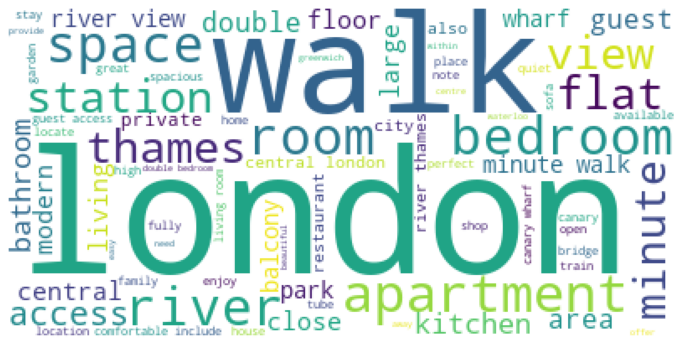

In [137]:
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(fcvdf.sum())
plt.imshow(Cloud) 
plt.axis("off");

### Task 7.2: For TF/IDF Weighting

<div class="alert alert-block alert-success">
    <b>Difficulty Level</b>: Easy, but you'll need to be patient!
</div>

In [140]:
tfidf.sum().sort_values(ascending=False)

walk                       17.022563
london                     16.703780
apartment                  15.922469
room                       14.825425
river                      13.599045
                             ...    
station also close          0.323158
apartment one               0.323158
castle station also         0.323158
apartment one benefit       0.323158
close station apartment     0.323158
Length: 2057, dtype: float64

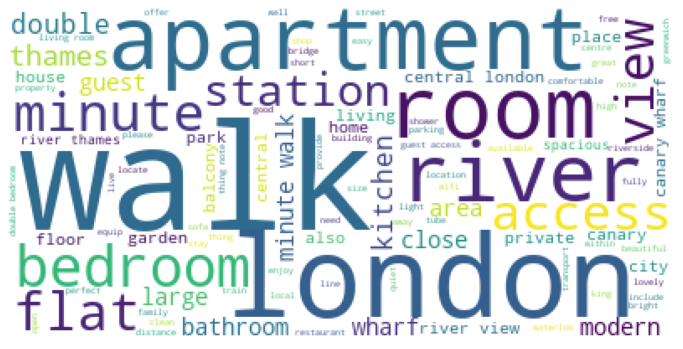

In [139]:
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(tfidf.sum())
plt.imshow(Cloud) 
plt.axis("off");

#### 7.2.3 Questions

- What does the `sum` represent for the count vectoriser?

It's a straightforward count of the number of times that a term appears in the corpus as a whole: we sum *down* each column where each cell represented a frequency for the term $i$ in document $d$. So it's simply: $\sum_{1..d}{i_d}$

- What does the `sum` represent for the TF/IDF vectoriser?

Here it's the sum of *weighted* values for each term across all documents in the corpus. So it's no longer a straightforward count, but rather a measure of *distinctive* terms (though it might also include less distinctive but more frequent terms) in the corpus.

## Task 8. Latent Dirchlet Allocation

<div class="alert alert-block alert-success">
    <b>&#128161; Tip</b>: I would give this a <em>low</em> priority. It's a commonly-used method, but on small data sets it really isn't much use and I've found its answers to be... unclear... even on large data sets.
</div>

Adapted from [this post](https://stackabuse.com/python-for-nlp-topic-modeling/) on doing LDA using sklearn. Most other examples use the `gensim` library.

In [141]:
vectorizer = CountVectorizer(ngram_range=(1,2)) # Notice change to ngram range (try 1,1 and 1,2 for other options)

### Task 8.1: Calculate Topics

In [142]:
vectorizer.fit(corpus) 
tcorpus = vectorizer.transform(corpus) # tcorpus for transformed corpus

LDA = LatentDirichletAllocation(n_components=3, random_state=42) # Might want to experiment with n_components too
LDA.fit(tcorpus)

LatentDirichletAllocation(n_components=3, random_state=42)

In [143]:
first_topic = LDA.components_[0]
top_words = first_topic.argsort()[-25:]

for i in top_words:
    print(vectorizer.get_feature_names_out()[i])

living room
guest access
modern
double
large
floor
area
balcony
bathroom
station
river view
flat
kitchen
living
guest
london
thames
access
bedroom
walk
view
apartment
space
room
river


In [144]:
for i,topic in enumerate(LDA.components_):
    as_markdown(f'Top 10 words for topic #{i}', ', '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-25:]]))

##### Top 10 words for topic #0

>living room, guest access, modern, double, large, floor, area, balcony, bathroom, station, river view, flat, kitchen, living, guest, london, thames, access, bedroom, walk, view, apartment, space, room, river


##### Top 10 words for topic #1

>place, restaurant, area, floor, guest, bathroom, central london, double, kitchen, close, minute walk, central, view, apartment, access, thames, bedroom, space, river, flat, station, room, minute, walk, london


##### Top 10 words for topic #2

>perfect, canary, canary wharf, locate, river view, also, flat, wharf, family, large, modern, station, view, double, area, thames, kitchen, walk, river, bathroom, space, room, london, bedroom, apartment


### Task 8.2: Maximum Likelihood Topic

In [145]:
topic_values = LDA.transform(tcorpus)
topic_values.shape

(328, 3)

In [146]:
pd.options.display.max_colwidth=20
srcdf['Topic'] = topic_values.argmax(axis=1)
srcdf.head()

,index,geometry,listing_url,name,description,amenities,price,description_norm,Topic
id,,,,,,,,,
36299,22,POINT (519476.34...,https://www.airb...,Kew Gardens 3BR ...,3 Bed House with...,"[""Extra pillows ...",245.0,house garden clo...,1
170702,76,POINT (537106.00...,https://www.airb...,A Double Room wi...,<b>The space</b>...,"[""Essentials"", ""...",60.0,space appartment...,1
90549,213,POINT (537979.60...,https://www.airb...,"Central, Luxury ...",•Central locatio...,"[""Hair dryer"", ""...",48.0,central location...,1
465781,364,POINT (547667.88...,https://www.airb...,Double room view...,<b>The space</b>...,"[""Washer"", ""Free...",30.0,space double roo...,1
504310,532,POINT (538587.23...,https://www.airb...,Luxury Riverview...,Located in Canar...,"[""Wifi"", ""Oven"",...",118.0,located canary w...,0


In [148]:
pd.options.display.max_colwidth=75
srcdf[srcdf.Topic==1].description_norm.head(10)

id
36299      house garden close thames river . walk  private road river nearby .  di...
170702     space appartment upper floor modernised secure building near canary wha...
90549      central location canary wharf  walk bank  excel centre  crossharbour  w...
465781     space double room  four storey block  . lift . view river thames . shar...
608438     newly renovate  totally equipped furnished modern apartment heart londo...
1670108    comfortable fairly flat east london  travel zone  minute central london...
1525275    charming house garden floor wonderful green waterside location  canada ...
1580666    please read things note  comfortable  clean  bright brand flat east lon...
2559765    cosy bedroom apartment ninth floor amazing river view  minute pimlico s...
4563354    london central neighbourhood . short walk waterloo  borough brixton . c...
Name: description_norm, dtype: object

In [150]:
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word', max_df=0.7, min_df=0.05)
topic_corpus = vectorizer.fit_transform(srcdf[srcdf.Topic==1].description.values) # tcorpus for transformed corpus

In [151]:
topicdf = pd.DataFrame(data=topic_corpus.toarray(),
                        columns=vectorizer.get_feature_names_out())

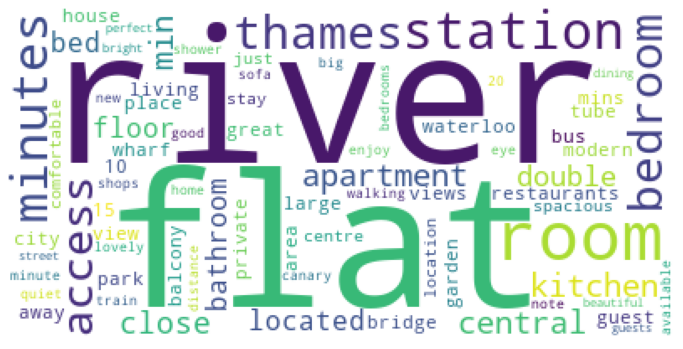

In [152]:
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(topicdf.sum())
plt.imshow(Cloud) 
plt.axis("off");

## Task 9. Word2Vec

<div class="alert alert-block alert-danger">
    <b>&#129327; Tip</b>: This algorithm works almost like magic. You should play with the configuration parameters and see how it changes your results.
</div>

### Task 9.1: Configure

In [153]:
from gensim.models.word2vec import Word2Vec

In [177]:
dims = 100
print(f"You've chosen {dims} dimensions.")

window = 3
print(f"You've chosen a window of size {window}.")

min_v_freq  = 0.005 # Don't keep words appearing less than 0.5% frequency
min_v_count = math.ceil(min_v_freq * srcdf.shape[0])
print(f"With a minimum frequency of {min_v_freq} and {srcdf.shape[0]:,} documents, minimum vocab frequency is {min_v_count:,}.")


You've chosen 100 dimensions.
You've chosen a window of size 7.
With a minimum frequency of 0.005 and 328 documents, minimum vocab frequency is 2.


### Task 9.2: Train

In [178]:
%%time 

corpus      = srcdf.description_norm.fillna(' ').values
#corpus_sent = [nltk.sent_tokenize(text) for text in corpus] # <-- with more formal writing this would work well
corpus_sent = [d.replace('.',' ').split(' ') for d in corpus] # <-- deals better with many short sentences though context may end up... weird
model       = Word2Vec(sentences=corpus_sent, vector_size=dims, window=window, epochs=200, 
                 min_count=min_v_count, seed=42, workers=1)

model.save(f"word2vec-d{dims}-w{window}.model") # <-- You can then Word2Vec.load(...) which is useful with large corpora

CPU times: user 4.85 s, sys: 133 ms, total: 4.98 s
Wall time: 4.6 s


### Task 9.3: Explore Similarities

This next bit of code only runs if you have calculated the frequencies above in the [Frequencies and Ngrams](#frequencies-and-ngrams) section.

In [179]:
pd.set_option('display.max_colwidth',150)

df = fcounts[1] # <-- copy out only the unigrams as we haven't trained anything else

n     = 14 # number of words
topn  = 7  # number of most similar words

selected_words = df[df['Ngram Size 1'] > 5].reset_index().level_0.sample(n, random_state=42).tolist()

words = []
v1    = []
v2    = []
v3    = []
sims  = []

for w in selected_words:
    try: 
        vector = model.wv[w]  # get numpy vector of a word
        #print(f"Word vector for '{w}' starts: {vector[:5]}...")
    
        sim = model.wv.most_similar(w, topn=topn)
        #print(f"Similar words to '{w}' include: {sim}.")
    
        words.append(w)
        v1.append(vector[0])
        v2.append(vector[1])
        v3.append(vector[2])
        sims.append(", ".join([x[0] for x in sim]))
    except KeyError:
        print(f"Didn't find {w} in model. Can happen with low-frequency terms.")
    
vecs = pd.DataFrame({
    'Term':words,
    'V1':v1, 
    'V2':v2, 
    'V3':v3,
    f'Top {topn} Similar':sims
})

vecs

,Term,V1,V2,V3,Top 7 Similar
0,english,0.659683,-1.301077,1.462678,"animal, traditional, storey, sink, eight, jogging, mini"
1,couple,-1.073242,-0.496572,-0.674585,"solo, traveller, adventurer, business, traveler, friend, suit"
2,incredible,1.426643,2.538283,1.022726,"intend, anyone, century, come, thanks, luxury, finishing"
3,road,1.768129,-3.909970,1.098689,"retreat, kings, academic, bidet, charm, culdesac, scenic"
4,living,-0.683262,2.518065,-0.768371,"live, reception, lounge, come, comfortable, double, both"
5,floor,0.239037,1.399509,1.486702,"bright, elevator, bedroom, lift, third, toilet, balcony"
6,hotel,1.365100,0.081858,0.104611,"slipper, helipad, robe, setup, head, professionally, star"
7,available,-3.324048,1.320373,2.127497,"june, secured, harrods, beautiful, projector, compact, landlord"
8,charm,0.689265,0.027260,0.999157,"road, historic, marsh, area, combine, posh, sightseeing"
9,equip,0.284879,1.438522,-2.153387,"automatic, functional, heat, code, induction, separate, prepare"


In [180]:
#print(model.wv.index_to_key) # <-- the full vocabulary that has been trained

### Task 9.4: Apply

We're going to make *use* of this further next week...

#### 9.4.1 Questions

- What happens when *dims* is very small (e.g. 25) or very large (e.g. 300)?

Training time is significantly longer for larger numbers of dimensions. You *should* also see that the apparent accuracy of the similarity scoring varies quite dramatically. With a small number of dimensions there is less separation between vectors so you'll see some odd things coming up as similar terms. With a large number of dimensions there is a lot of separation, but with a fairly small training data set you'll probably get a small number of *close* similar terms for many words (i.e. the distance between terms increases so the truly 'close' vectors are fewer, though Word2Vec will calculate similarity for *all* terms to the target so this change won't be obvious).

- What happens when *window* is very small (e.g. 2) or very large (e.g. 8)?

Training time is significantly longer as the context increases. You *should* see that increasing the context window draws out more subtle, longer-distance relationships between words, while a small context window draws out common substitutions/pairings. I tend to find that a middle-ground of 3-4 is often a good place to be for short texts, whereas more might be appropriate for longer, more format documents.

## Task 10. Processing the Full File

<div class="alert alert-block alert-danger">
    <b>&#9888; Warning</b>: This code can take <i>some time</i> (<b>&gt; 5 minutes on a M1, &gt; 8 minutes on a well-resourced Intel Mac</b>) to run, so <b>don't run this</b> until you've understood what we did before!</div>

You will get a warning about `"." looks like a filename, not markup` -- this looks a little scary, but is basically suggesting that we have a description that consists only of a '.' or that looks like some kind of URL (which the parser thinks means you're trying to pass it something to download). 

In [181]:
%%time 

gdf['description_norm'] = ''
gdf['description_norm'] = gdf.description.apply(normalise_document, remove_digits=True, special_char_removal=True)

CPU times: user 8min 6s, sys: 5.26 s, total: 8min 11s
Wall time: 8min 10s


You cannot serialise a list to a feather file, if you don't drop `amenities_lst` you will get this error: 

> UnicodeEncodeError: 'utf-8' codec can't encode characters in position... surrogates not allowed

In [ ]:
gdf.drop(columns=['amenities_lst']).to_feather(os.path.join('data','geo',f'{fn.replace(".","-with-nlp.")}'))

<div class="alert alert-block alert-success">
    <b>&#128161; Tip</b>: saving an intermediate file at this point is useful because you've done quite a bit of <em>expensive</em> computation. You <em>could</em> restart-and-run-all and then go out for the day, but probably easier to just save this output and then, if you need to restart your analysis at some point in the future, just remember to deserialise amenities back into a list format.
</div>

### Now Explore!

Try re-running the above code on the full data set (Count Vectorisation, TF/IDF, LDA, and Word2Vec) and see how your results change. Training the word2vec model may take some time.

## Applications



The above is _still_ only the results for the 'luxury' apartments _alone_. At this point, you would probably want to think about how your results might change if you changed any of the following:

1. Using one of the other data sets that we created, or even the entire data set!
2. Applying the CountVectorizer or TfidfVectorizer _before_ selecting out any of our 'sub' data sets.
3. Using the visualisation of information from \#2 to improve our regex selection process.
4. Reducing, increasing, or constraining (i.e. `ngrams=(2,2)`) the size of the ngrams while bearing in mind the impact on processing time and interpretability.
5. Filtering by type of listing or host instead of keywords found in the description (for instance, what if you applied TF/IDF to the entire data set and then selected out 'Whole Properties' before splitting into those advertised by hosts with only one listing vs. those with multiple listings?).
6. Linking this back to the geography.

Over the next few weeks we'll also consider alternative means of visualising the data!

## Resources

There is a lot more information out there, including a [whole book](https://www.nltk.org/book/) and your standard [O'Reilly text](http://www.datascienceassn.org/sites/default/files/Natural%20Language%20Processing%20with%20Python.pdf).

And some more useful links:
- [Pandas String Contains Method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html)
- [Using Regular Expressions with Pandas](https://kanoki.org/2019/11/12/how-to-use-regex-in-pandas/)
- [Summarising Chapters from Frankenstein using TF/IDF](https://towardsdatascience.com/using-tf-idf-to-form-descriptive-chapter-summaries-via-keyword-extraction-4e6fd857d190)